# Kernel Density Estimation

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from simple_colors import *
from copy import deepcopy
import sympy as sy
import sympy.stats

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

### Scratch playing with sympy

In [2]:
t, u, v, w, x, y, z  = sy.symbols('t u v w x y z',real =  True)
f = sy.Function('f')
def f(x):
    if x == 0:
        return 0
    else:
        return x + 1

In [3]:
y = np.array(range(3))
z = y.reshape(3,1)
print('y =',y)
z + y


y = [0 1 2]


array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

In [4]:
y = sy.symbols('y')
sy.pprint(y+sy.pi)
f(y)

y + π


y + 1

## Isotropic Kernels

In [5]:
h = sy.symbols('h',positive = True)
r = sy.symbols('r',positive = True, integer = True)
t, u, v, w, x, y, z  = sy.symbols('t u v w x y z',real = True)

### Hermite functions

#### Constructing a density kernel whose integral is one and whose integral against low order polynomials vanishes

Define a kernel in terms of Hermite polynomials so that integrates to one and integrates to zero for higher order polynomials

In [6]:
y = sy.symbols('y', real = True)
h = sy.symbols('h', positive = True)
def sy_hermite_kernel(y = sy.symbols('y', real = True), band_width = sy.symbols('h', positive = True), r = 1, only_coef = False):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
#    import sympy as sy
    wt = sy.exp(-y*y) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
    tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1)) #the kernel should integrate to one, 
        #and the kernel integrated against y, y^2, ..., y^r should be zero
#    print(tot_int)
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
    if only_coef:
        return coef
    print(coef)
#    ktilde = coef.dot(k)
#    integk = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integk =',integk)
    ktilde = coef.dot(k.subs(y,y/band_width)/band_width) #form the isotropic kernel and insert the bandwidth dependency
#    integ = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integ =',integ)
#    print(band_width)
#    print(ktilde)
    return coef.dot(k.subs(y,y/band_width)/band_width)

In [10]:
test_kernel_sy = sy_hermite_kernel(r=1)
print(type(test_kernel_sy))
print('kernel =',test_kernel_sy)
integ = sy.integrate(test_kernel_sy,(y,-sy.oo,sy.oo))
print('integ =',integ)
test_kernel_sy = sy_hermite_kernel(r=2,only_coef = True)
print(test_kernel_sy)

Matrix([[1/sqrt(pi)]])
<class 'sympy.core.mul.Mul'>
kernel = exp(-y**2/h**2)/(sqrt(pi)*h)
integ = 1
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])


#### Look at this kernel for different values of the order and the bandwidth
A smaller bandwidth makes a peakier kernel

A higher order means that there is potentially higher accuracy, although it may mean that the KDE has negative values

In [11]:
h = sy.symbols('h', positive = True)
y = sy.symbols('y', real = True)
rarray = sy.Matrix([sy.Integer(1), sy.Integer(2), sy.Integer(3)])
nr = rarray.shape[0]

Matrix([[1/sqrt(pi)]])
ktilde = \frac{e^{- y^{2}}}{\sqrt{\pi}}
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
ktilde = \frac{\left(\frac{3}{2} - y^{2}\right) e^{- y^{2}}}{\sqrt{\pi}}
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])
ktilde = \frac{\left(4 y^{4} - 20 y^{2} + 15\right) e^{- y^{2}}}{8 \sqrt{\pi}}


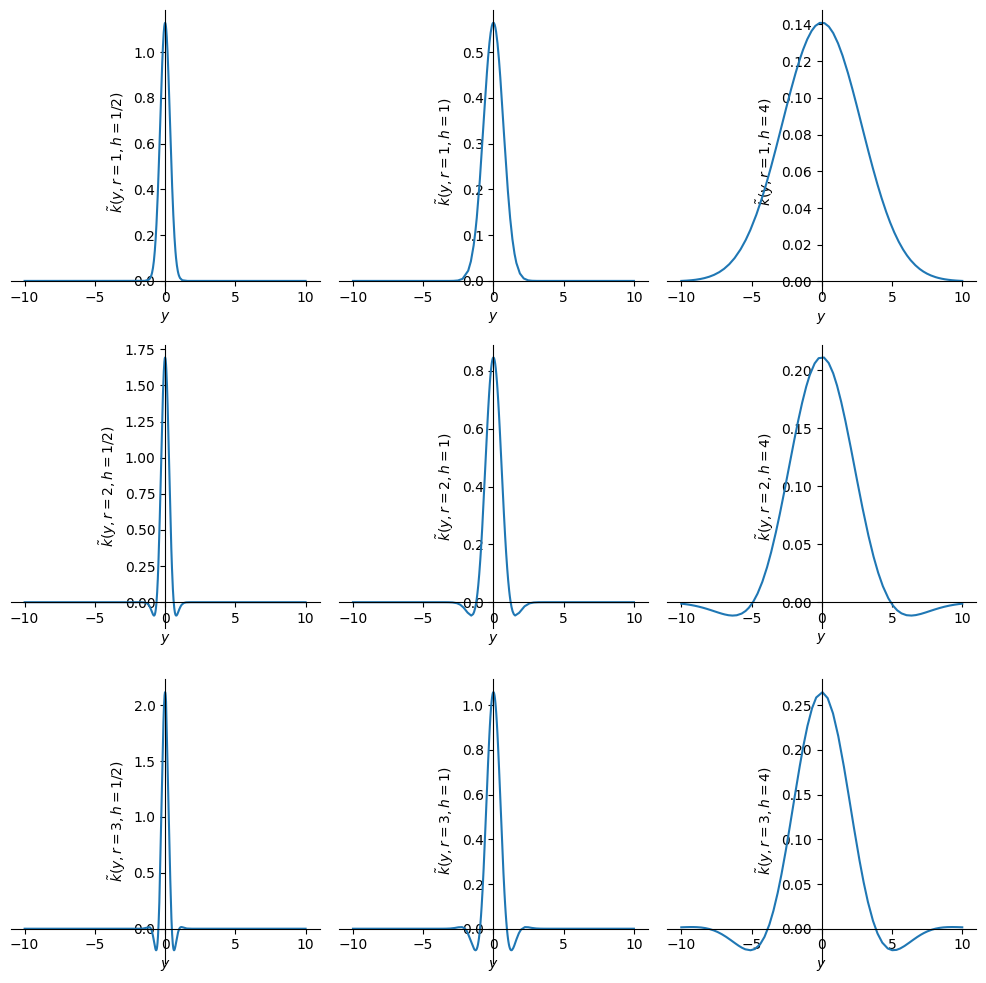

In [12]:
harray = sy.Matrix([sy.Rational(1/2), sy.Rational(1), sy.Rational(4)])
nh = harray.shape[0]
p = [];
for rr in range(nr):
    rval = rarray[rr]
    ktilde_sy = sy.simplify(sy_hermite_kernel(y,h,rval))
    print('ktilde =',sy.latex(ktilde_sy.subs(h,1)))
    for hh in range(nh):
        hval = harray[hh]
        p.append(sy.plot(ktilde_sy.subs(h,hval),ylabel = r'$\tilde k(y,r='+str(rval)+',h='+str(hval)+')$', show = False))
sy.plotting.PlotGrid(nr,nh, *p, size = (10,10));

#### Smoothing a density with respect to these kernels

In [13]:
r = 2
trial_density_sy = sy.stats.density(sy.stats.Normal(x,0,1))(y)
print(trial_density_sy)
ktilde_sy = sy_hermite_kernel(y,h,r)
integ = sy.integrate(ktilde_sy,(y,-sy.oo,sy.oo))
print(integ)
smoothed_density_sy = sy.integrate(trial_density_sy.subs(y,y-z)*ktilde_sy.subs(y,z),(z,-sy.oo,sy.oo))
print(smoothed_density_sy)

sqrt(2)*exp(-y**2/2)/(2*sqrt(pi))
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
1
3*(2 - erfc(y/(h*sqrt(h**2/2 + 1))))*sqrt(h**2 + 2)*exp(-y**2/h**2)*exp(y**2/(h**2*(h**2/2 + 1)))/(8*sqrt(pi)*(h**2/2 + 1)) + 3*sqrt(h**2 + 2)*exp(-y**2/h**2)*exp(y**2/(h**2*(h**2/2 + 1)))*erfc(y/(h*sqrt(h**2/2 + 1)))/(8*sqrt(pi)*(h**2/2 + 1)) - sqrt(2)*(-sqrt(pi)*h*sqrt(h**2/2 + 1)/(2*y) + sqrt(pi)*(-1/2 - y**2/(h**2*(h**2/2 + 1)))*(-2*h*sqrt(h**2/2 + 1)*exp(-y**2/(h**2*(h**2/2 + 1)))/y - 2*sqrt(pi)*(2 - erfc(y/(h*sqrt(h**2/2 + 1)))))*exp(y**2/(h**2*(h**2/2 + 1)))/2)*exp(-y**2/h**2)/(4*pi**(3/2)*(h**2/2 + 1)**(3/2)) - sqrt(2)*(sqrt(pi)*h*sqrt(h**2/2 + 1)/(2*y) + sqrt(pi)*(-1/2 - y**2/(h**2*(h**2/2 + 1)))*(2*h*sqrt(h**2/2 + 1)*exp(-y**2/(h**2*(h**2/2 + 1)))/y - 2*sqrt(pi)*erfc(y/(h*sqrt(h**2/2 + 1))))*exp(y**2/(h**2*(h**2/2 + 1)))/2)*exp(-y**2/h**2)/(4*pi**(3/2)*(h**2/2 + 1)**(3/2)) - y**2*(2 - erfc(y/(h*sqrt(h**2/2 + 1))))*sqrt(h**2 + 2)*exp(-y**2/h**2)*exp(y**2/(h**2*(h**2/2 + 1)))/(4*sqrt(pi)*h**2*(h**2/2 + 

Matrix([[1/sqrt(pi)]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])


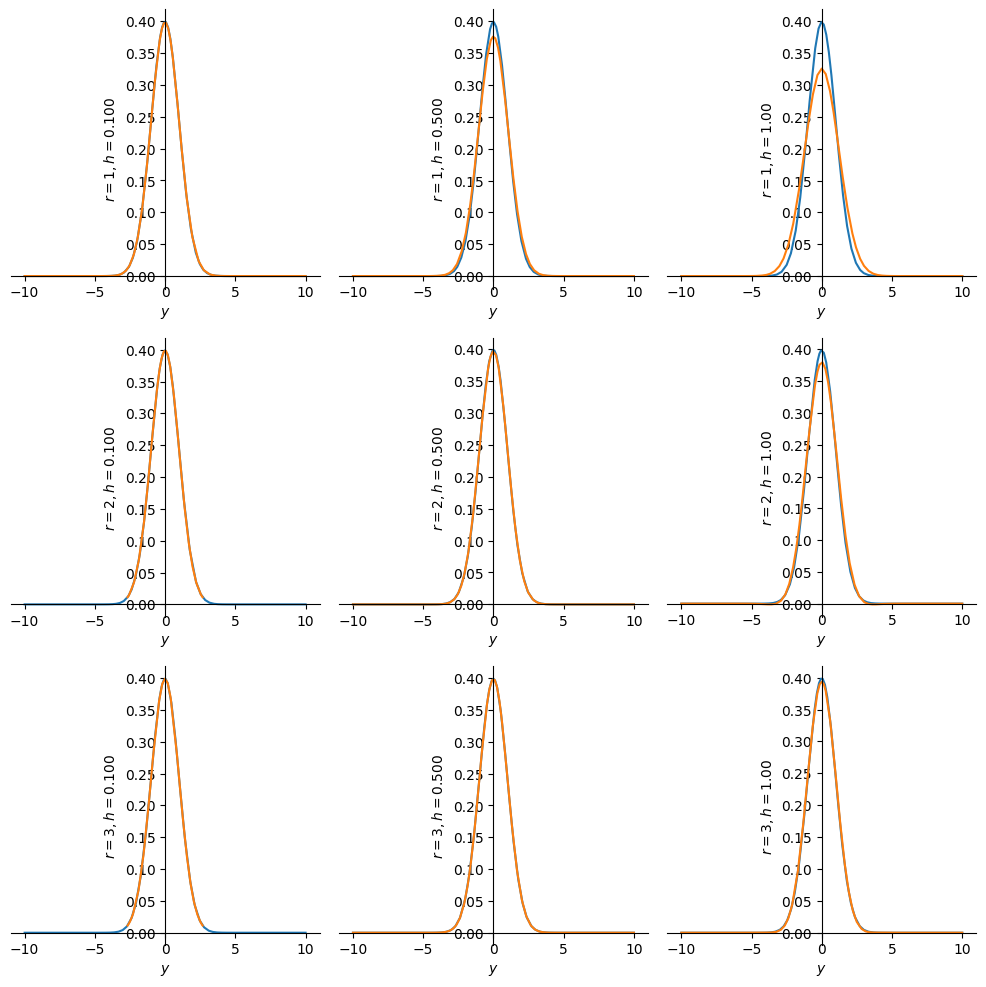

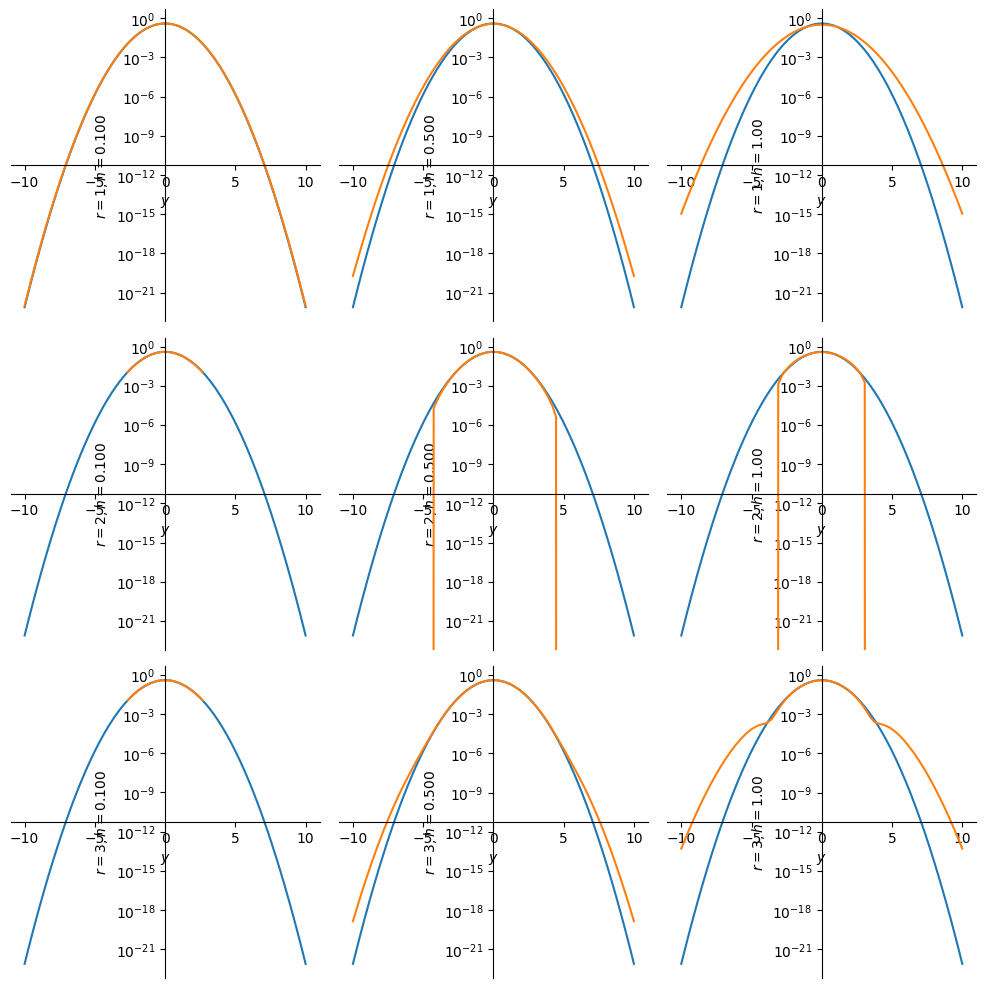

In [14]:
harray = sy.Matrix([sy.Rational(1/10), sy.Rational(1/2), sy.Rational(1)])
nh = harray.shape[0]
p = []
plog = []
for rr in range(nr):
    rval = rarray[rr]
    ktilde_sy = sy_hermite_kernel(y,h,rval)
    smoothed_density_sy = sy.integrate(trial_density_sy.subs(y,y-z)*ktilde_sy.subs(y,z),(z,-sy.oo,sy.oo))
    for hh in range(nh):
        hval = harray[hh]
        p.append(sy.plot(trial_density_sy,smoothed_density_sy.subs(h,hval),ylabel = r'$r='+str(rval)+', h='+str(sy.N(hval,3))+'$', show = False))
        plog.append(sy.plot(trial_density_sy,smoothed_density_sy.subs(h,hval),ylabel = r'$r='+str(rval)+', h='+str(sy.N(hval,3))+'$', yscale = 'log', show = False))
sy.plotting.PlotGrid(nr,nh, *p, size = (10,10));
sy.plotting.PlotGrid(nr,nh, *plog, size = (10,10));

In [15]:
ktilde_sy = sy_hermite_kernel(y,h,1)
ktilde_n = sy.lambdify((y,h),ktilde_sy)
print('ktilde(0,1) =',ktilde_sy.subs([(y,0),(h,1)]),'=',sy.N(ktilde_sy.subs([(y,0),(h,1)])),'=',ktilde_n(0,1))
yval = np.linspace(-3,3,7)
print('yval =',yval)
print(yval.shape)
ktilde_n(yval.reshape(7,1)-yval,1)

Matrix([[1/sqrt(pi)]])
ktilde(0,1) = 1/sqrt(pi) = 0.564189583547756 = 0.5641895835477563
yval = [-3. -2. -1.  0.  1.  2.  3.]
(7,)


array([[5.64189584e-01, 2.07553749e-01, 1.03334927e-02, 6.96265260e-05,
        6.34911734e-08, 7.83543327e-12, 1.30865062e-16],
       [2.07553749e-01, 5.64189584e-01, 2.07553749e-01, 1.03334927e-02,
        6.96265260e-05, 6.34911734e-08, 7.83543327e-12],
       [1.03334927e-02, 2.07553749e-01, 5.64189584e-01, 2.07553749e-01,
        1.03334927e-02, 6.96265260e-05, 6.34911734e-08],
       [6.96265260e-05, 1.03334927e-02, 2.07553749e-01, 5.64189584e-01,
        2.07553749e-01, 1.03334927e-02, 6.96265260e-05],
       [6.34911734e-08, 6.96265260e-05, 1.03334927e-02, 2.07553749e-01,
        5.64189584e-01, 2.07553749e-01, 1.03334927e-02],
       [7.83543327e-12, 6.34911734e-08, 6.96265260e-05, 1.03334927e-02,
        2.07553749e-01, 5.64189584e-01, 2.07553749e-01],
       [1.30865062e-16, 7.83543327e-12, 6.34911734e-08, 6.96265260e-05,
        1.03334927e-02, 2.07553749e-01, 5.64189584e-01]])

#### Computing the quality of merit of the density kernel

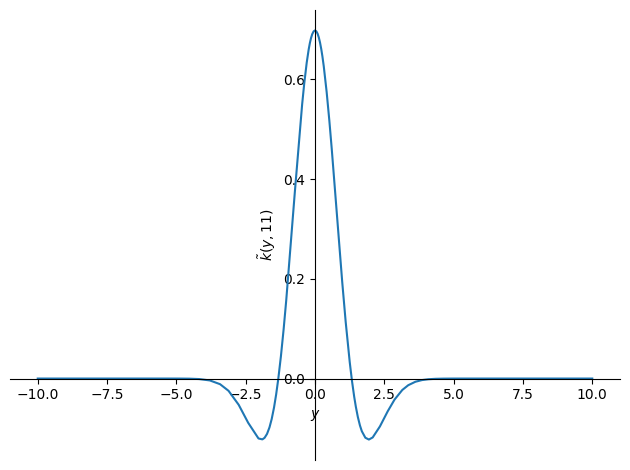

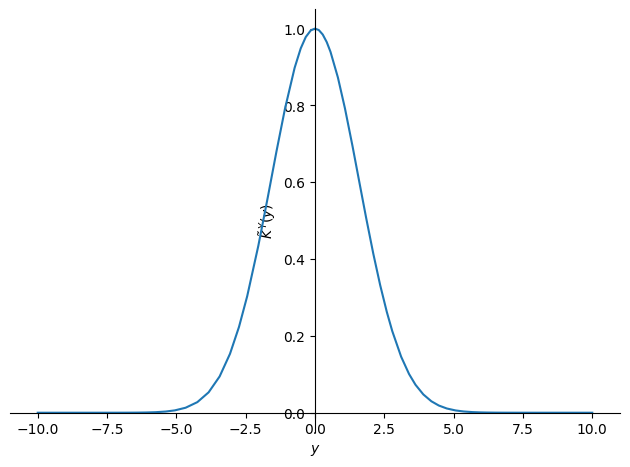

pi**(1/4)*(-sqrt(2)*h**4*z**2 + 7*sqrt(2)*h**4/4 + 5*sqrt(pi)*h**2 + 3*sqrt(2)*pi/2)*exp(z**2*(-1/2 + sqrt(pi)/(sqrt(2)*h**2 + 2*sqrt(pi))))/(sqrt(sqrt(2)*h**2 + 2*sqrt(pi))*(h**4 + 2*sqrt(2)*sqrt(pi)*h**2 + 2*pi))


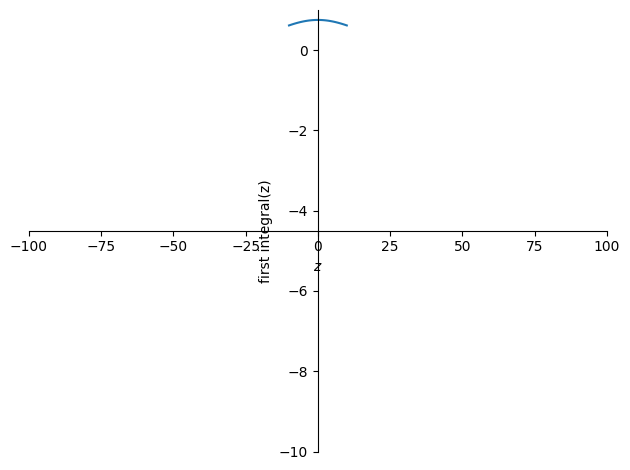

0.337053145879381


In [27]:
h = sy.symbols('h',positive = True)
ktilde = sy_hermite_kernel(y,h,2) #density kernel
hval = 1
sy.plot(ktilde.subs(h,hval),ylabel = r'$\tilde k(y,'+str(hval)+'1)$')
KYtilde = sy.exp(-y**2/2/(sy.sqrt(2*sy.pi))) #reproducing kernel
sy.plot(KYtilde,ylabel = r'$\tilde K^Y(y)$')
integone = sy.simplify(sy.integrate(ktilde.subs(h,1) * KYtilde.subs(y,(y-z)*h),(y,-sy.oo,sy.oo)))
print(integone)
sy.plot(integone.subs(h,1/10),ylabel = 'first integral(z)', xlim = [-100,100], ylim=[-10,1]);
print(sy.N(integone.subs([(h,1/10), (z,20)])))
#print(sy.N(integone))
#kqual = sy.simplify(KYtilde.subs(y,0) - 2*sy.integrate(ktilde * KYtilde.subs(y,y*h),(y,-sy.oo,sy.oo)) \
#    + sy.integrate(integone * ktilde.subs(y,z),(z,-sy.oo,sy.oo)))
#print(kqual)

In [292]:
print(sy.N(integone.subs([(h,1/10), (z,1000)])))

-2.12014388584230e-862


In [283]:
wt = sy.exp(-z*z/2)
#partial = sy.integrate((-sy.sqrt(2)*h**4*z**2 + 7*sy.sqrt(2)*h**4/4 + 5*sy.sqrt(sy.pi)*h**2 ) * wt,(z,-sy.oo,sy.oo))
partial = sy.integrate((sy.exp(z**2*(-1/2 + sy.sqrt(sy.pi)/(sy.sqrt(2)*h**2 + 2*sy.sqrt(sy.pi))))) * wt,(z,-sy.oo,sy.oo))
print(partial)

TypeError: 'xlim' is an invalid keyword argument for print()

In [ ]:
sy.plot(kqual, (h,0.01,10), xscale = 'log', yscale = 'log', ylabel = 'Smoothing Quality', axis_center = (0.008,1e-9));

## Numeric Isotropic Kernels

### Define Hermite kernels

In [13]:
def hermite_kernel(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    print(coef)
    poly = sp.special.hermite(0)
    print(poly)
    k = sp.special.hermite(0)(y)*coef[0] #initialize a vector of kernel values
    print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [14]:
y = np.linspace(-1,2,5)
print('y =',y)
print(type(y))
k = hermite_kernel(y)
print('k =',k)

y = [-1.   -0.25  0.5   1.25  2.  ]
<class 'numpy.ndarray'>
[[0.398942280401433]]
 
1
[0.398942280401433 0.398942280401433 0.398942280401433 0.398942280401433
 0.398942280401433]
k = [0.241970724519143 0.386668116802849 0.352065326764300 0.182649085389022
 0.0539909665131881]


## Experiment with KDE

### Generate some $x$ points

In [33]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
print(coord_wts)
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
wtiidpts = np.multiply(iidpts,coord_wts)
print(wtiidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

[1.   0.5  0.25]
iid pts [[0.79459427 0.71714334 0.62791046]
 [0.45892418 0.29790162 0.56111718]
 [0.20402867 0.03901888 0.66307795]
 ...
 [0.1158514  0.1840347  0.31850213]
 [0.96699074 0.02285133 0.55528241]
 [0.80785936 0.50526162 0.18639416]]
[[0.79459427 0.35857167 0.15697761]
 [0.45892418 0.14895081 0.1402793 ]
 [0.20402867 0.01950944 0.16576949]
 ...
 [0.1158514  0.09201735 0.07962553]
 [0.96699074 0.01142567 0.1388206 ]
 [0.80785936 0.25263081 0.04659854]]
sobol pts [[0.4784042  0.99021115 0.88676966]
 [0.58578445 0.11518499 0.32690579]
 [0.09148062 0.31494511 0.04258613]
 ...
 [0.718967   0.29654007 0.0396558 ]
 [0.2287678  0.02427586 0.32592894]
 [0.83248592 0.89923529 0.88969966]]


### Generate some $y=f(x)$ points

In [41]:
def testfun(x,coord_wts = 1):
    wtx = np.multiply(x,coord_wts)
    y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    return y

In [35]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

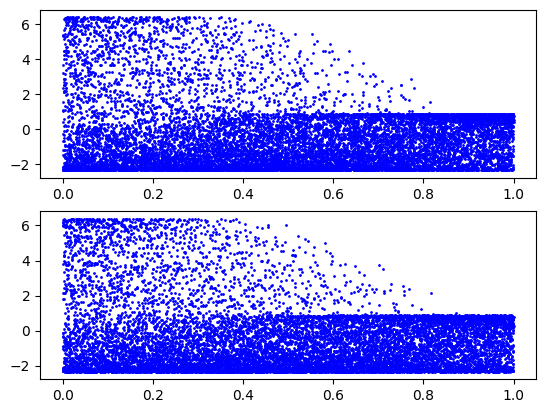

In [36]:
fig,ax = plt.subplots(2)
ax[0].plot(iidpts, yiid, 'b.', markersize = 2)
ax[1].plot(sobpts, ysob, 'b.', markersize = 2);

### Compute the scipy kernel density estimator

In [42]:
def scipy_kde(data,where_to_evaluate):
    density_estimate = stats.gaussian_kde(data.T)
    kdevalues = density_estimate(where_to_evaluate)
    return kdevalues, density_estimate    
    #return density_estimate

In [38]:
right = np.max(ysob)
left = np.min(ysob)
step = (right-left)/500
xvalues = np.arange(left,right,step)
small_n = int(np.sqrt(n))

In [39]:
kdeiidsmall, trash = kde(yiid[:small_n],xvalues)
print('small_n',small_n)
print('kdeiidsmall',kdeiidsmall[:10])
kdeiid, trash = kde(yiid,xvalues)
kdesobsmall, trash = kde(ysob[:small_n],xvalues)
kdesob, trash = kde(ysob,xvalues)

small_n 64
kdeiidsmall [0.18740514 0.18919018 0.19094745 0.19267625 0.19437589 0.19604571
 0.19768508 0.19929341 0.20087013 0.2024147 ]


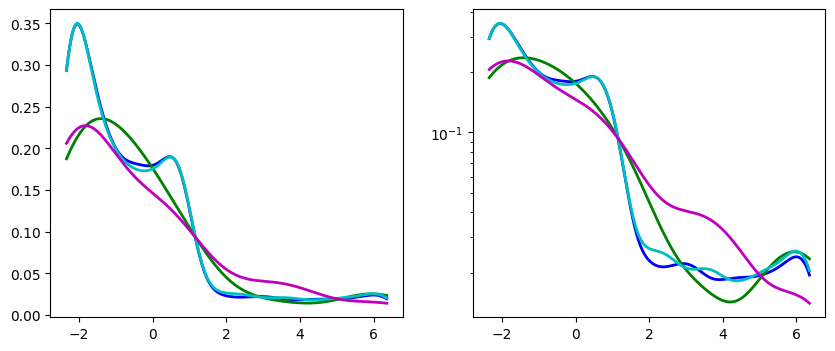

In [40]:
fig,ax = plt.subplots(1,ncols=2,figsize = (10,4))
for ii in range(2):
#    ax[ii].plot(xvalues, stats.norm.pdf(xvalues), 'k-', linewidth = 2);
    ax[ii].plot(xvalues, kdeiid, 'b-', linewidth = 2)
    ax[ii].plot(xvalues, kdeiidsmall, 'g-', linewidth = 2)
    ax[ii].plot(xvalues, kdesob, 'c-', linewidth = 2)
    ax[ii].plot(xvalues, kdesobsmall, 'm-', linewidth = 2);
ax[1].set_yscale('log')

### Compute the vanilla kernel density estimator

In [44]:
def vanilla_kde(data,where_to_evaluate,kernel = hermite_kernel(),band_width = 1):
    density_estimate = lambda y : kernel((y - data.T)/band_width).mean(1)
    kdevalues = density_estimate(where_to_evaluate)
    return kdevalues, density_estimate    
    #return density_estimate

NameError: name 'hermite_kernel' is not defined